In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode, lsim
from scipy import signal
import control.matlab as control
from IPython.display import Math, display

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

# Vergleich Einstellregeln

## System 2. Ordnung

\begin{align*}
    G_\mathrm{S} &= \frac{5}{(1 + 2 \, s) \, (1 + 0.007 \, s)}
\end{align*}

In [3]:
KS = 5
T1 = 2
T2 = 0.7
sys = signal.lti([KS], [T1 * T2, T1 + T2, 1])

In [4]:
t = np.linspace(0, 10, 1001)
u = np.ones(t.size) * 3 

## Polkompensation

In [5]:
TN = (T1 + T2)
TV = T1 * T2 / (T1 + T2)
KP = 1

In [6]:
f = np.logspace(-2, 5)

# Strecke
sys = control.tf([KS], [T1 * T2, T1 + T2, 1])
mag, phase, w = control.bode(sys, f, plot = False)

# Regler
reg = control.tf([KP * T1 * T2, KP * (T1 + T2), KP], [T1 + T2, 0])
magReg, phaseReg, wReg = control.bode(reg, f, plot = False)

# Offener Kreis
G0 = sys * reg
magG0, phaseG0, wG0 = control.bode(G0, f, plot = False)

# Geschlossener Kreis
Gw = G0 / (1 + G0)
magGw, phaseGw, wGw = control.bode(Gw, f, plot = False)

## Betragsoptimum
Eine dominierende Zeitkonstate $\Rightarrow$ PI-Regler

In [7]:
TSum = T2
KpOpt = T1 / (2 * KS * TSum)
regOpt = control.tf([KpOpt * T1, KpOpt], [T1, 0])

In [8]:
G0Opt = sys * regOpt
GwOpt = G0Opt / (1 + G0Opt)
magGwOpt, phaseGwOpt, wGwOpt = control.bode(GwOpt, f, plot = False)

In [9]:
ySimOpt, tSimOpt, _ = control.lsim(GwOpt, U=u, T=t)

C:\WPy64-31050\python-3.10.5.amd64\lib\site-packages\control\timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


## Frequenzkennlinienverfahren
### Spezifikation

\begin{align*}
    T_\mathrm{r} &= 5 \\
    \Delta h & = 0,1 \\
    e_\infty &= 0~\text{bei Sprung}
\end{align*}

In [10]:
Tr = 1.5
dH = 0.1

In [11]:
wc = 1.5 / Tr
Math(r'\omega_\mathrm{c} =' + str(wc))

<IPython.core.display.Math object>

In [12]:
phi = 70 - 100 * dH
Math(r'\varphi_\mathrm{m} = ' + str(phi))

<IPython.core.display.Math object>

In [13]:
G01Fkv = sys * control.tf([1], [1, 0])
G01Fkv

TransferFunction(array([5.]), array([1.4, 2.7, 1. , 0. ]))

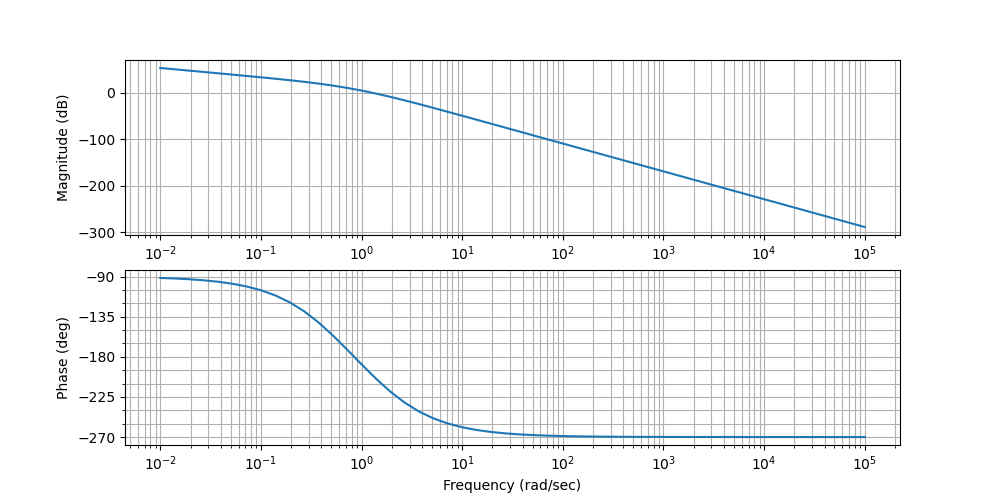

In [14]:
fig = plt.figure(figsize=(10, 5))
magG01Fkv, phaseG01Fkv, wG01Fkv=control.bode(G01Fkv, f)

### Abgelesene Werte bei $\omega_\mathrm{c}$

In [15]:
magFkvWc, phaseFkvWc, wFkvWc = control.bode(G01Fkv, np.linspace(wc, wc, 1))

In [16]:
Math(r'|G_{0,1}(j\omega_\mathrm{c})| = ' + str(control.mag2db(magFkvWc[0])))

<IPython.core.display.Math object>

In [17]:
Math(r'\arg \, G_{0,1}(j\omega_\mathrm{c}) = ' + str(np.rad2deg(phaseFkvWc[0])))

<IPython.core.display.Math object>

### Phasenkorrektur

In [18]:
phaseKorr = -(180 - 60) - np.rad2deg(phaseFkvWc[0])
Math(r'\varphi_\mathrm{kor} = ' + str(phaseKorr))

<IPython.core.display.Math object>

In [19]:
TnFkv = 1 / wc * np.tan(phaseKorr * np.pi / 180)
Math(r'T_\mathrm{N} =' + str(TnFkv))

<IPython.core.display.Math object>

In [20]:
G02Fkv = G01Fkv * control.tf([TnFkv, 1], [1])
G02Fkv

TransferFunction(array([12.64594605,  5.        ]), array([1.4, 2.7, 1. , 0. ]))

In [21]:
magFkvWc2, phaseFkvWc2, wFkvWc2 = control.bode(G02Fkv, np.linspace(wc, wc, 1), plot = False)

In [22]:
KpFkv = 1 / (magFkvWc2[0])
Math('K_\mathrm{p,fkv} =' + str(KpFkv))

<IPython.core.display.Math object>

In [23]:
regFkv = KpFkv * control.tf([TnFkv, 1], [1, 0])


In [24]:
G0Fkv = sys * regFkv
GwFkv = G0Fkv / (1 + G0Fkv)
magG01Fkv, phaseG01Fkv, wG01Fkv = control.bode(G01Fkv, f, plot=False)
magG02Fkv, phaseG02Fkv, wG02Fkv = control.bode(G02Fkv, f, plot=False)
magG0Fkv, phaseG0Fkv, wG0Fkv = control.bode(G0Fkv, f, plot=False)

In [25]:
magGwFkv, phaseGwFkv, wGwFkv = control.bode(GwFkv, f, plot=True)

In [26]:
ySimFkv, tSimFkv, _ = control.lsim(GwFkv, U=u, T=t)

## Verfahren nach Reinisch

In [27]:
avRein = 1.4
TnRein = T1
TSum = T2
KpRein = TnRein / (avRein * KS * TSum)

In [28]:
regRein = control.tf([KpRein * TnRein, KpRein], [TnRein, 0])

In [29]:
G0Rein = sys * regRein
GwRein = G0Rein / (1 + G0Rein)
magGwRein, phaseGwRein, wGwRein = control.bode(GwRein, f, plot = False)

In [30]:
ySimRein, tSimRein, _ = control.lsim(GwRein, U=u, T=t)

In [31]:
KpFkv

0.20071796769724506

In [32]:
KpRein

0.4081632653061225

## Vergleich

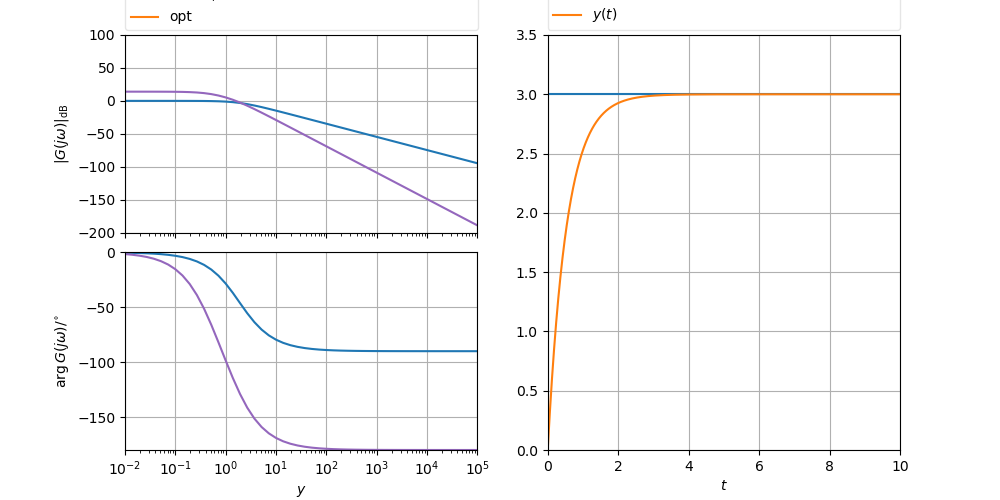

In [33]:
output = widgets.Output()

with output:
    fig = plt.figure(figsize=(10, 5))
    ax3 = plt.subplot(122)
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(223)

plt.subplots_adjust(wspace=0.2, hspace=0.1)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.grid() 
ax2.grid()
ax3.grid()
[label.set_visible(False) for label in ax1.get_xticklabels()]
ax2.set_xlabel(r"$y$")
ax3.set_xlabel(r"$t$")
ax1.set_ylabel(r"$|G(j \omega)|_{\mathrm{dB}}$")
ax2.set_ylabel(r"$\mathrm{arg}\, G(j\omega)/^{\circ}$")

magCLPlot, = ax1.semilogx(wGw, control.mag2db(magGw), label=r'$G_\mathrm{w}:~K_\mathrm{p}=$' + str(KP))
phaseCLPlot, = ax2.semilogx(wGw, np.rad2deg(phaseGw))
magCLOptPlot, = ax1.semilogx(wGwOpt, control.mag2db(magGwOpt), label=r'opt')
phaseCLOptPlot, = ax2.semilogx(wGwOpt, np.rad2deg(phaseGwOpt))
magCLReinPlot, = ax1.semilogx(wGwRein, control.mag2db(magGwRein), label=r'rein')
phaseCLReinPlot, = ax2.semilogx(wGwRein, np.rad2deg(phaseGwRein))
magCLFkvPlot, = ax1.semilogx(wGwFkv, control.mag2db(magGwFkv), label=r'Fkv')
phaseCLFkvPlot, = ax2.semilogx(wGwFkv, np.rad2deg(phaseGwFkv))

ax1.semilogx(w, control.mag2db(mag), label=r'$G_\mathrm{s}$')
ax2.semilogx(w, np.rad2deg(phase))

simInputPlot, = ax3.plot([], [], label=r'$w(t)$')
simOutputPlot, = ax3.plot([], [], label=r'$y(t)$')
simOutputOptPlot, = ax3.plot(tSimOpt, ySimOpt, '--', label=r'$opt$')
simOutputReinPlot, = ax3.plot(tSimRein, ySimRein, label=r'$rein$')
simOutputFkvPlot, = ax3.plot(tSimFkv, ySimFkv, label=r'$Fkv$')

handlesAx, labelsAx = ax3.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.5475, 0.94, 0.3525, .15), loc=3,
           ncol=4, mode="expand", borderaxespad=0., framealpha=0.5)

handlesAx, labelsAx = ax1.get_legend_handles_labels()
handelsLeg = fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.125, 0.94, 0.3525, .15), loc=3,
           ncol=4, mode="expand", borderaxespad=0., framealpha=0.5)

sliderFreq = widgets.FloatSlider(value=1,
                                    min=0.1,
                                    max=5,
                                    step=0.01,
                                    description='Kp')

checkBetragOpt = widgets.Checkbox(value=False,
                                    description='Betragsoptimum',
                                    disabled=False)


checkReinisch = widgets.Checkbox(value=False,
                                    description='Reinisch',
                                    disabled=False)

checkFkv = widgets.Checkbox(value=False,
                                    description='Fkv',
                                    disabled=False)

def calcSystem(_):
   
    KP = sliderFreq.value
    
    reg = control.tf([KP * T1 * T2, KP * (T1 + T2), KP], [T1 + T2, 0])
    G0 = sys * reg
    magG0, phaseG0, wG0 = control.bode(G0, f, plot = False)

    Gw = G0 / (1 + G0)
    magGw, phaseGw, wGw = control.bode(Gw, f, plot = False)
    
    magCLPlot.set_data(wGw, control.mag2db(magGw))
    phaseCLPlot.set_data(wGw, np.rad2deg(phaseGw))
    handelsLeg.get_texts()[0].set_text(r'$G_\mathrm{w}:~K_\mathrm{p}=$' + str(KP))
       
    ySim, tSim, xSim = control.lsim(Gw, U=u, T=t)
    
    if checkBetragOpt.value:
        magCLOptPlot.set_alpha(1.0)
        phaseCLOptPlot.set_alpha(1.0)
        magCLOptPlot.set_label(r'opt')
        handelsLeg.get_texts()[1].set_text(r'opt')
        
        simOutputOptPlot.set_alpha(1.0)
    else:
        magCLOptPlot.set_alpha(0.0)
        phaseCLOptPlot.set_alpha(0.0)
       # handelsLeg.get_texts()[1].set_text(r'')
        simOutputOptPlot.set_alpha(0.0)
    
    if checkReinisch.value:
        magCLReinPlot.set_alpha(1.0)
        phaseCLReinPlot.set_alpha(1.0)
        simOutputReinPlot.set_alpha(1.0)
    else:
        magCLReinPlot.set_alpha(0.0)
        phaseCLReinPlot.set_alpha(0.0)
        simOutputReinPlot.set_alpha(0.0)
    
    if checkFkv.value:
        magCLFkvPlot.set_alpha(1.0)
        phaseCLFkvPlot.set_alpha(1.0)
        simOutputFkvPlot.set_alpha(1.0)
    else:
        magCLFkvPlot.set_alpha(0.0)
        phaseCLFkvPlot.set_alpha(0.0)
        simOutputFkvPlot.set_alpha(0.0)         

    
    simInputPlot.set_data(t, u)
    simOutputPlot.set_data(tSim, ySim)
    ax3.set_xlim([0, t[-1]])
    ax3.set_ylim([0, 3.5])
    ax1.set_xlim([wGw[0], wGw[-1]])
    ax2.set_xlim([wGw[0], wGw[-1]])
    ax1.set_ylim([-200,100])
    ax2.set_ylim([-180, 0])
    fig.canvas.draw()

sliderFreq.observe(calcSystem, names='value')
checkBetragOpt.observe(calcSystem, names='value')
checkReinisch.observe(calcSystem, names='value')
checkFkv.observe(calcSystem, names='value')

calcSystem(_)

inputControls = Box([sliderFreq, checkBetragOpt, checkReinisch, checkFkv])
inputControls.layout = make_box_layout()

HBox([inputControls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))#